In [1]:
%%capture
%matplotlib inline
import seaborn as sns
sns.set_context('notebook')
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
plt.plot([0,1],[1,0])
from neuronunit.optimisation import make_sim_tests
import numpy as np
from IPython.display import display, HTML
from neuronunit.plottools import plot_score_history1
from neuronunit.optimisation.optimization_management import check_binary_match
from neuronunit.optimisation.optimization_management import inject_and_plot_model
import pandas as pd

# Simulated Data 
and select model parameters that are free to vary


In [2]:
%%capture
model_type="HH"
fps = ['g_L','g_Na','g_K','vr'] 
import make_sim_tests
sim_tests, OM, target = make_sim_tests.test_all_objective_test(fps,model_type=model_type)


# Meta Parameters

In [3]:
MU = 10 
NGEN = 50


# Utilizing Parallel Rheobase
would probably speed this up substantially
Uncomment optimization_management 857-865

In [4]:
results = sim_tests.optimize(backend=model_type,\
        protocol={'allen': False, 'elephant': True},\
            MU=MU,NGEN=NGEN,plot=True,free_parameters=fps)


GA Generation Progress: 100%|██████████| 44/44 [45:26<00:00, 61.96s/it]


In [5]:
opt = results['pf'][0].dtc
OM.tests = opt.tests
opt = OM.format_test(opt)
opt.self_evaluate()
opt = OM.get_agreement(opt)
display(opt.agreement)

,RheobaseTest,TimeConstantTest,RestingPotentialTest,InputResistanceTest,CapacitanceTest,InjectedCurrentAPWidthTest,InjectedCurrentAPAmplitudeTest,InjectedCurrentAPThresholdTest,total
observations,112.5 pA,106.09472029042023 ms,-65.86556320141725 mV,2787378915.357602 kg*m**2/(s**3*A**2),3.806253958005885e-11 s**4*A**2/(kg*m**2),0.003304166666666667 s,110.55732035525426 mV,-64.46993811034352 mV,NaN
predictions,112.5 pA,106.02592215695144 ms,-64.91424421018209 mV,2961004040.226626 kg*m**2/(s**3*A**2),3.580742231909841e-11 s**4*A**2/(kg*m**2),0.0033583333333333334 s,109.19478245856641 mV,-63.51755886343717 mV,NaN
scores,0,0.000258731,0.123059,3.67615,0.0239167,0.00656144,0.00492877,0.00591074,19.252036


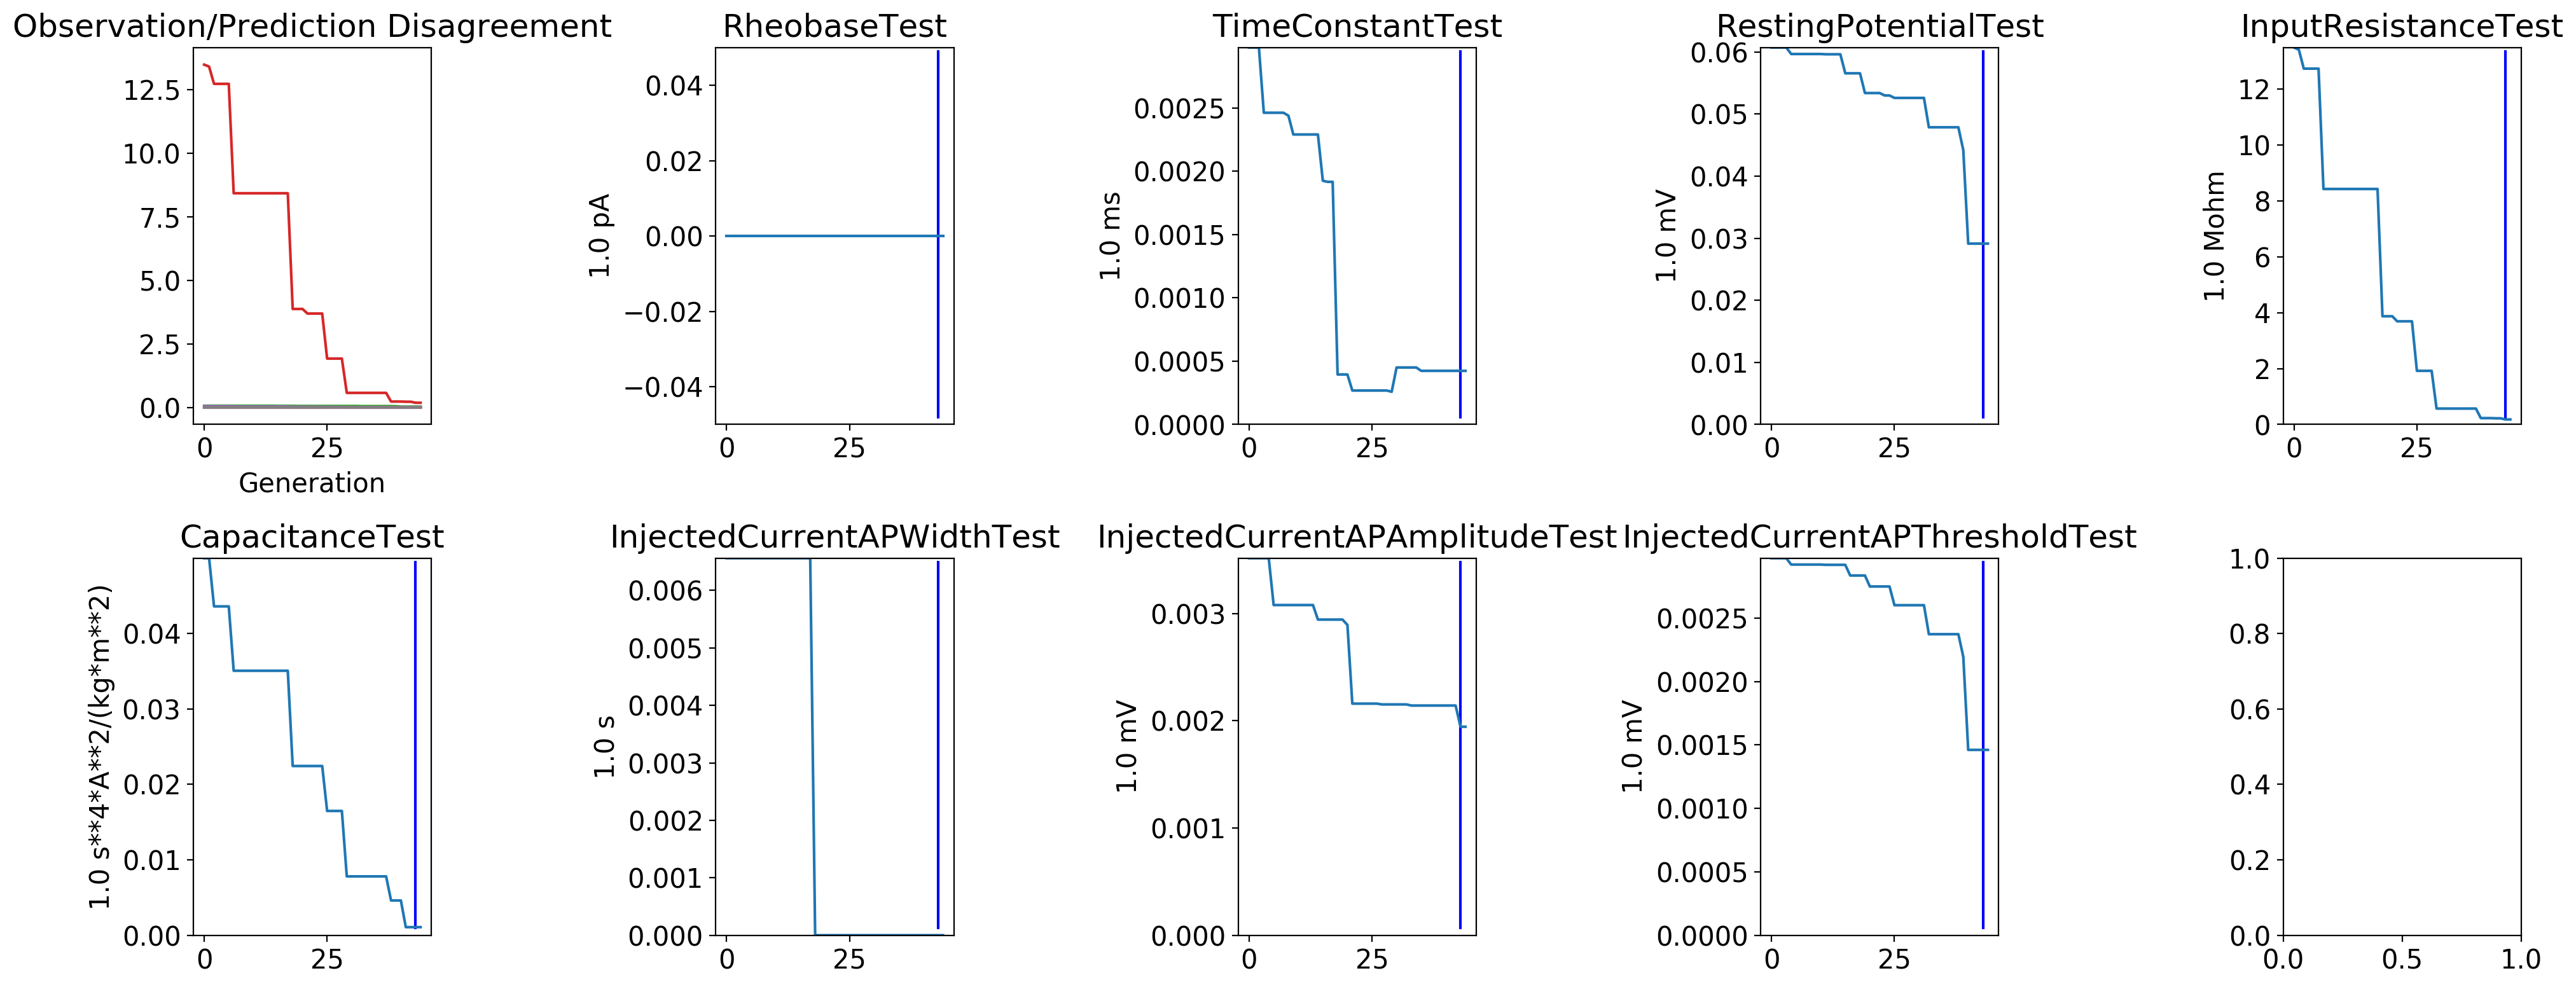

In [6]:

plt = plot_score_history1(results)
plt.show()


<Figure size 640x480 with 0 Axes>

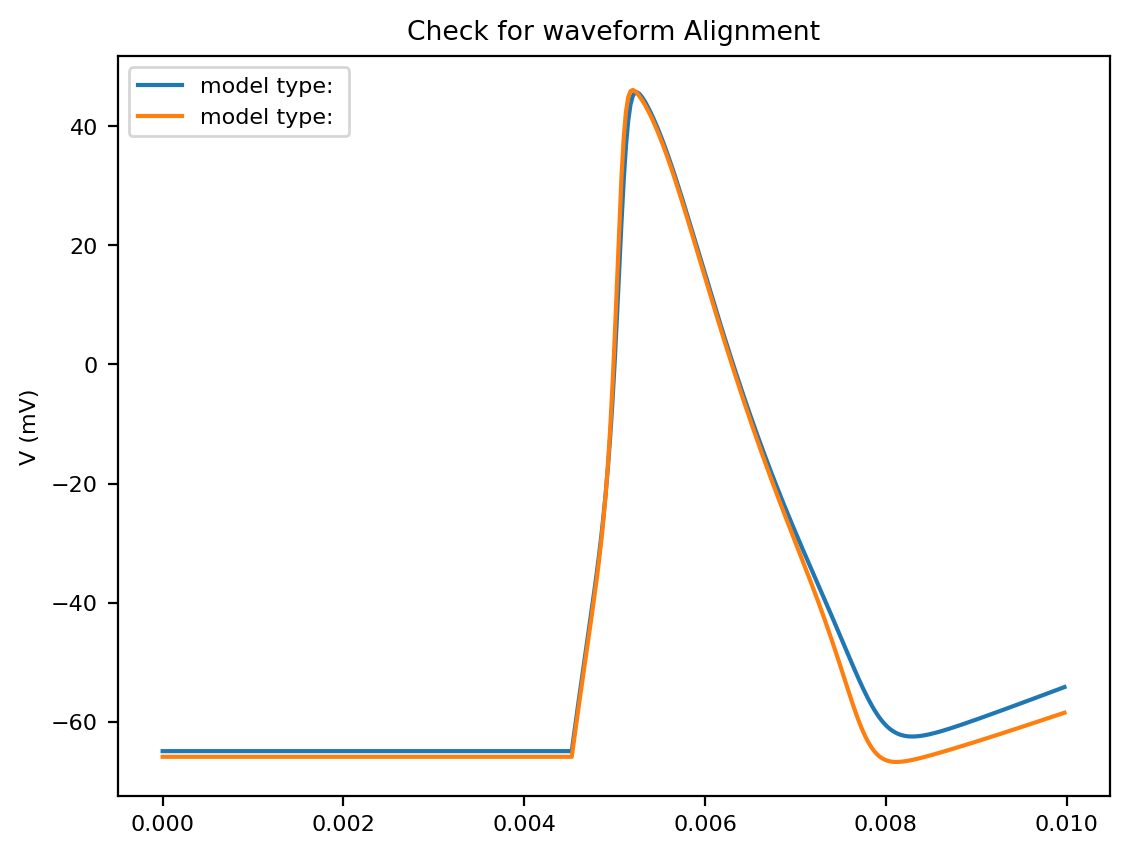

In [7]:
model = target.dtc_to_model()
check_binary_match(opt,target,snippets=True)
target = OM.format_test(target)
simulated_data_tests = target.tests
#


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

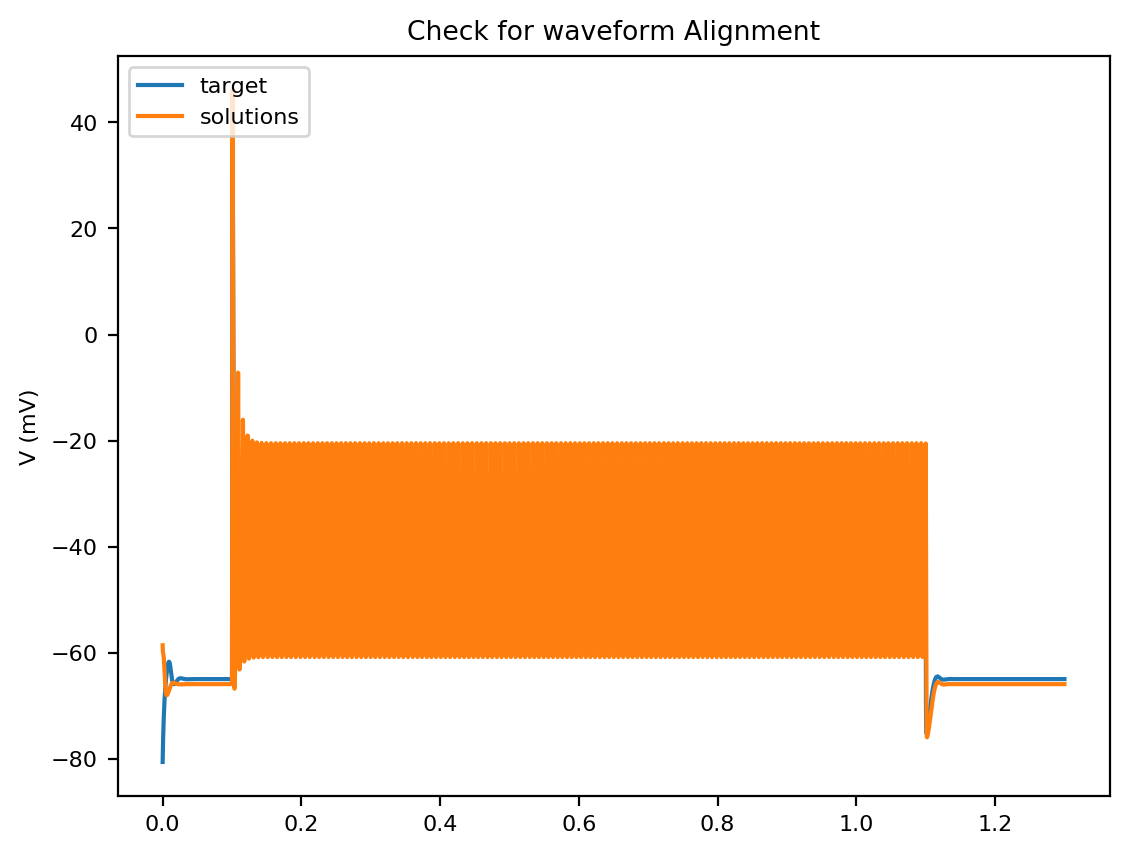

In [8]:
check_binary_match(opt,target,snippets=False)


In [10]:
display(pd.DataFrame([opt.attrs]))
import copy
temp = {}
for k in opt.attrs.keys():
    temp[k] = target.attrs[k]
display(pd.DataFrame([temp]))

,g_K,g_L,g_Na,vr
0,28.928257,0.24914,95.71378,-80.528143


,g_K,g_L,g_Na,vr
0,41.451405,0.254041,133.004685,-58.542979


What where the values of model parameters that where held constant?


In [11]:
df0 = opt.dtc_to_model().default_attrs
df1 = target.dtc_to_model().default_attrs
hc = {}
for k,v in df0.items():
    if k not in opt.attrs.keys():
        assert df0[k] == df1[k]
        hc[k] = v        
display(pd.DataFrame([hc]))     

,C_m,E_L,E_K,E_Na
0,1.0,-54.387,-77.0,50.0


In [12]:
from neuronunit.optimisation.model_parameters import MODEL_PARAMS
a_range = MODEL_PARAMS["HH"]['g_Na']
grid_a = np.linspace(a_range[0],a_range[1],10)
b_range = MODEL_PARAMS["HH"]['g_K']
grid_b = np.linspace(b_range[0],b_range[1],10);

100%|██████████| 10/10 [01:31<00:00,  9.15s/it]


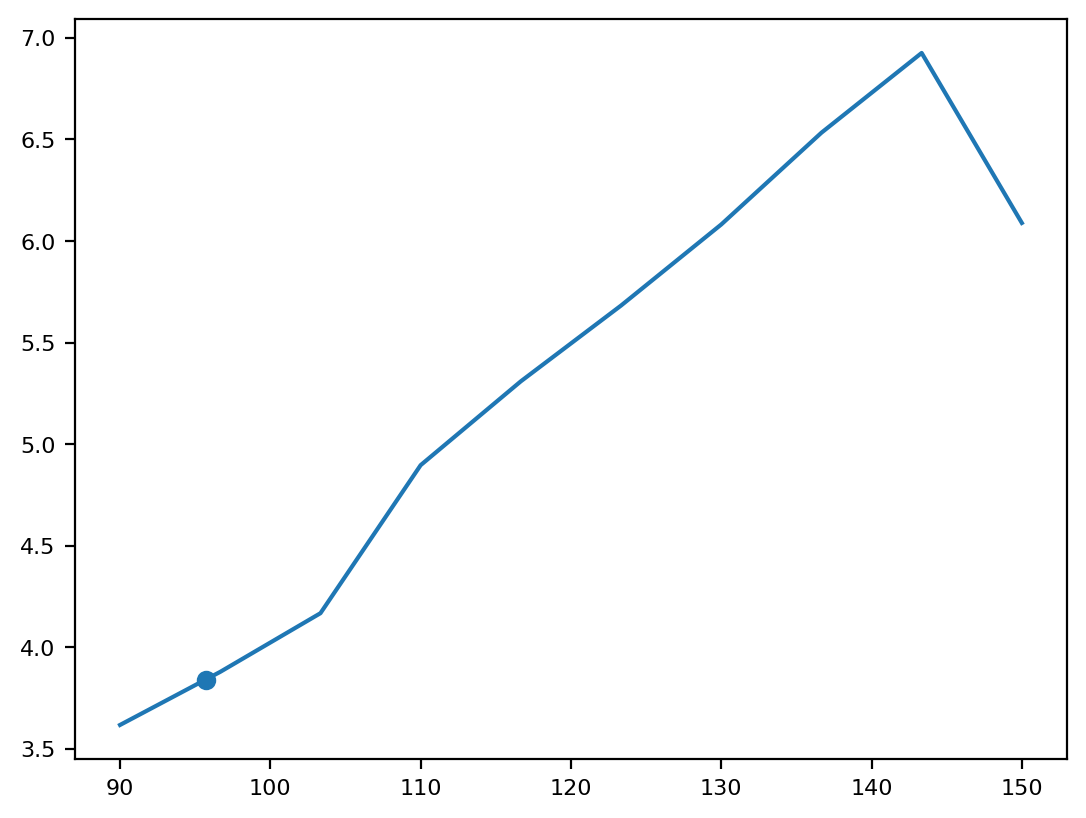

In [13]:
opt_sum = np.sum(opt.SA.values)
for_scatter = (opt.attrs['g_Na'],opt_sum)
from tqdm import tqdm
collect = []
mutant = copy.copy(opt)
for a in tqdm(grid_a):
    # non random mutation
    mutant.attrs['g_Na'] = a
    # Evaluate NU test suite
    mutant.self_evaluate()
    # sum components (optional)
    fit = np.sum(mutant.SA.values)
    collect.append(fit)
plt.plot(grid_a,collect)
plt.scatter(for_scatter[0],for_scatter[1],label='optima')
    

In [18]:
%time
pred = opt.tests[0].generate_prediction(opt.dtc_to_model())
print(pred)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs
{'value': array(0.) * pA}


In [21]:
from neuronunit.tests.fi import RheobaseTestP
rtp = RheobaseTestP(opt.tests[0].observation)

In [23]:
#%time
#pred = rtp.generate_prediction(opt.dtc_to_model())
#print(pred)